## 作成した特徴量を使ってモデルを学習するぞい

In [1]:
from __future__ import annotations
import itertools
import dataclasses
from typing import List, Union

import sklearn
import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

In [2]:
TRAIN = pd.read_csv("data/preprocessed_train.csv", index_col=None, header=0).set_index("PassengerId")
TEST = pd.read_csv("data/preprocessed_test.csv", index_col=None, header=0).set_index("PassengerId")
display(TRAIN)
display(TEST)

,IntSex,Pclass,Under10YearsOld,IsPair,Parch,EmbarkedAtCherboug,Survived
PassengerId,,,,,,,
1,0,3,0,1,0,0,0
2,1,1,0,1,0,1,1
3,1,3,0,0,0,0,1
4,1,1,0,1,0,0,1
5,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...
887,0,2,0,0,0,0,0
888,1,1,0,0,0,0,1
889,1,3,0,1,2,0,0


,IntSex,Pclass,Under10YearsOld,IsPair,Parch,EmbarkedAtCherboug
PassengerId,,,,,,
892,0,3,0,0,0,0
893,1,3,0,1,0,0
894,0,2,0,0,0,0
895,0,3,0,0,0,0
896,1,3,0,1,1,0
...,...,...,...,...,...,...
1305,0,3,0,0,0,0
1306,1,1,0,0,0,1
1307,0,3,0,0,0,0


In [9]:
@dataclasses.dataclass(frozen=True)
class Result:
    model: sklearn.base.ClassifierMixin
    train: pd.DataFrame
    test: pd.DataFrame
    submit: pd.DataFrame


@dataclasses.dataclass(frozen=True)
class Score:
    name: str
    train_scores: List[float]
    test_scores: List[float]

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            {
                f"train_{self.name}": self.train_scores,
                f"test_{self.name}": self.test_scores,
            }
        )

    def __post_init__(self):
        if len(self.train_scores) != len(self.test_scores):
            raise ValueError("length is not same")

    @property
    def length(self):
        return len(self.train_scores)


@dataclasses.dataclass(frozen=True)
class CVResult:
    fit_time: List[float]
    score_time: List[float]
    scores: List[Score]

    def to_dataframe(self) -> pd.DataFrame:
        result = pd.DataFrame(
            {
                "fit_time": self.fit_time,
                "score_time": self.score_time,
            }
        )
        for score in self.scores:
            result = pd.concat([result, score.to_dataframe()], axis=1)

        return result


@dataclasses.dataclass(frozen=True)
class CVResults:
    params: List[Union[str, int]]
    results: List[CVResult]

    def __post_init__(self):
        if len(self.params) != len(self.results):
            raise ValueError("params and length is not same!")

    @classmethod
    def from_dict(cls, dict_results: dict) -> CVResults:
        return CVResults(params=dict_results.keys(), results=dict_results.values())

    def to_describe_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            {
                k: v.to_dataframe().describe().loc["mean", :]
                for k, v in zip(self.params, self.results)
            }
        ).transpose()

    def plot_and_display_table(self, plot_target="accuracy"):
        df = self.to_describe_dataframe()
        df[[f"train_{plot_target}", f"test_{plot_target}"]].plot(grid=True)
        display(df)


@dataclasses.dataclass
class RandomForestParams:
    n_estimators: int
    max_depth: int
    min_samples_split: int
    min_samples_leaf: int
    random_state: int = 0

    def to_string(self) -> str:
        return ", ".join([f"{k}={v}" for k, v in dataclasses.asdict(self).items()])


## とりあえず学習
- train: 0.84
- test: 0.76(submitした)

In [4]:
def train_random_forest_classifier(train: pd.DataFrame, test: pd.DataFrame, randomforest_kwarg: dict ={}) -> Result:
    randomforest = RandomForestClassifier(**randomforest_kwarg)
    randomforest.fit(TRAIN.drop("Survived", axis=1), TRAIN.Survived)

    display( randomforest.feature_importances_)
    display(randomforest.score(TRAIN.drop("Survived", axis=1), TRAIN.Survived))

    submit = pd.DataFrame({
        "PassengerId": TEST.index,
        "Survived": randomforest.predict(TEST)
    })
    display(submit)

    return Result(
        model=randomforest,
        train=train,
        test=test,
        submit=submit
    )

train_random_forest_classifier(TRAIN, TEST)

array([0.52624085, 0.22392858, 0.06444845, 0.04756774, 0.08674466,
       0.05106972])

0.8406285072951739

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


Result(model=RandomForestClassifier(), train=             IntSex  Pclass  Under10YearsOld  IsPair  Parch  \
PassengerId                                                   
1                 0       3                0       1      0   
2                 1       1                0       1      0   
3                 1       3                0       0      0   
4                 1       1                0       1      0   
5                 0       3                0       0      0   
...             ...     ...              ...     ...    ...   
887               0       2                0       0      0   
888               1       1                0       0      0   
889               1       3                0       1      2   
890               0       1                0       0      0   
891               0       3                0       0      0   

             EmbarkedAtCherboug  Survived  
PassengerId                                
1                             0         0  
2  

## k-cross-validationしよう
過学習のアレみるなら、交差検証したほうが良さげ

baseline: `test_score = 0.815980`

In [16]:
def random_forest_classifier_cross_validation(
    train: pd.DataFrame,
    model: sklearn.base.ClassifierMixin,
    cv: int = 10,
) -> CVResult:
    cv_results = cross_validate(
        model,
        train.drop("Survived", axis=1),
        train.Survived,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        scoring=["accuracy", "roc_auc"],
    )

    return CVResult(
        fit_time=cv_results["fit_time"],
        score_time=cv_results["score_time"],
        scores=[
            Score(
                name=name,
                train_scores=cv_results[f"train_{name}"],
                test_scores=cv_results[f"test_{name}"],
            )
            for name in ["accuracy", "roc_auc"]
        ],
    )


(
    random_forest_classifier_cross_validation(TRAIN, RandomForestClassifier())
    .to_dataframe()
    .mean()
)


fit_time          0.176791
score_time        0.030068
train_accuracy    0.829281
test_accuracy     0.803645
train_roc_auc     0.880495
test_roc_auc      0.853509
dtype: float64

### 特徴量を一つ削ってみる

In [17]:
RESULTS_1_LESS_FEATURES = CVResults.from_dict({
    str(params): random_forest_classifier_cross_validation(
        TRAIN[list(params) + ["Survived"]], RandomForestClassifier(random_state=0)
    )
    for params in itertools.combinations(TEST.columns, len(TEST.columns) - 1)
})


In [18]:
display(
    RESULTS_1_LESS_FEATURES.to_describe_dataframe().sort_values(
        "test_accuracy", ascending=False
    )
)


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
"('IntSex', 'Pclass', 'Under10YearsOld', 'Parch')",0.156591,0.027815,0.820801,0.809263,0.871894,0.851983
"('IntSex', 'Under10YearsOld', 'IsPair', 'Parch')",0.159420,0.030436,0.806335,0.795755,0.818280,0.793046
"('IntSex', 'Pclass', 'Under10YearsOld', 'IsPair')",0.168207,0.028541,0.811448,0.791348,0.867296,0.858360
"('IntSex', 'Pclass', 'IsPair', 'Parch')",0.170285,0.030833,0.812196,0.775568,0.865517,0.833530
"('Pclass', 'Under10YearsOld', 'IsPair', 'Parch')",0.160125,0.030807,0.719792,0.711648,0.739721,0.709149


一つ消してダメなら消す必要なさそう

**特徴量はそのまま使うことにする**

というか、決定木ベースのアルゴリズムだと特徴量の削減はあまり意味ないか。。
学習過程で与えられた特量量のいち部を使って分類やってみて、最もいいやつを云々とかやっているし。

### randomforestのパラメータをチューニングしてみよう
https://engineering.linecorp.com/ja/blog/abuser-analysis-hyperparameter-tuning-using-random-forests/
↑をなぞってみる

順々に最適な値として持ってしまっているが、本当は組み合わせで最適化する必要あり

#### max_depth

In [19]:
RESULTS_MAX_DEPTH = CVResults.from_dict({
    max_depth: random_forest_classifier_cross_validation(
        TRAIN, RandomForestClassifier(max_depth=max_depth, random_state=0)
    )
    for max_depth in range(1, 30)
})

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
1,0.156135,0.029453,0.783140,0.783408,0.836495,0.834688
2,0.161512,0.027375,0.799600,0.789076,0.847467,0.845206
3,0.172225,0.029535,0.816811,0.812584,0.856414,0.850638
4,0.171627,0.032898,0.823295,0.812584,0.865644,0.851378
5,0.166946,0.028043,0.826662,0.812634,0.874031,0.859560
6,0.160740,0.028105,0.828408,0.808152,0.878260,0.852000
7,0.154747,0.027105,0.829156,0.807016,0.880285,0.852839
8,0.189524,0.035114,0.829156,0.803658,0.880437,0.853693
9,0.188008,0.031703,0.829156,0.804782,0.880479,0.853640
10,0.172127,0.032641,0.829156,0.804782,0.880443,0.853640


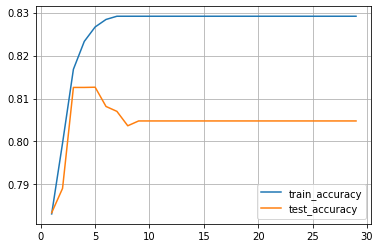

In [20]:
RESULTS_MAX_DEPTH.to_describe_dataframe()[["train_accuracy", "test_accuracy"]].plot(grid=True)
display(RESULTS_MAX_DEPTH.to_describe_dataframe())

In [21]:
MAX_DEPTH_RANGE=range(4, 11)

#### n_estimator
ブレブレだけど、10ぐらいで良さそう

In [22]:
RESULTS_N_ESTIMATOR = CVResults.from_dict({
    n_estimator: random_forest_classifier_cross_validation(
        TRAIN, RandomForestClassifier(n_estimators=n_estimator, random_state=0)
    )
    for n_estimator in range(1, 100)
})

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
1,0.004459,0.005195,0.822795,0.799151,0.868049,0.838647
2,0.007124,0.006032,0.824543,0.801398,0.873838,0.840130
3,0.008373,0.005945,0.824668,0.793533,0.876129,0.844062
4,0.008606,0.005971,0.827161,0.799151,0.877205,0.853031
5,0.010098,0.005862,0.826912,0.795780,0.878366,0.848008
...,...,...,...,...,...,...
95,0.167008,0.028933,0.829281,0.804769,0.880408,0.852731
96,0.173812,0.031159,0.829281,0.803658,0.880426,0.852731
97,0.167037,0.031122,0.829281,0.803658,0.880432,0.852838
98,0.162279,0.028106,0.829156,0.804782,0.880468,0.853801


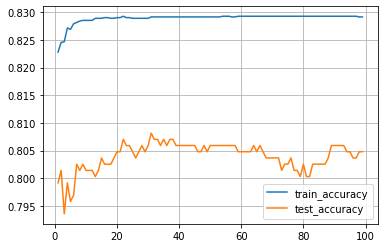

In [23]:
RESULTS_N_ESTIMATOR.plot_and_display_table()

In [24]:
N_ESTIMATOR_RANGE = range(30, 101)

#### max_feature
（なんか特徴量をそもそも削るのは上でやったので、削らないのが良さそうな気がする）

特徴量がそもそも少ないので、下手に弄らずにデフォルト（`auto`）で良さそう

最適化対象から外す


In [25]:
RESULTS_MAX_FEATURES = CVResults.from_dict(
    {
        max_features: random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                max_features=max_features,
                random_state=0
            ),
        )
        for max_features in range(1, len(TEST.columns) + 1)
    }
)


dataset features Index(['IntSex', 'Pclass', 'Under10YearsOld', 'IsPair', 'Parch'], dtype='object')


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
1,0.170672,0.029292,0.829156,0.803658,0.880379,0.854036
2,0.164203,0.027844,0.829156,0.804782,0.880443,0.853640
3,0.168415,0.032114,0.829156,0.802534,0.880467,0.854144
4,0.160885,0.029527,0.829156,0.805905,0.880503,0.853821
5,0.169447,0.027948,0.829156,0.803658,0.880443,0.853108


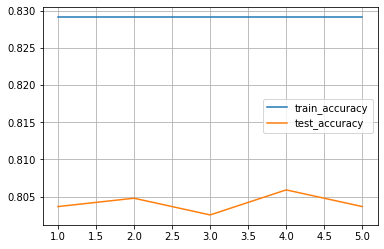

In [26]:
print("dataset features", TEST.columns)
RESULTS_MAX_FEATURES.plot_and_display_table()

#### min_samples_split

In [27]:
RESULTS_MIN_SAMPLES_SPLIT = CVResults.from_dict(
    {
        min_samples_split: random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                min_samples_split=min_samples_split,
                random_state=0
            ),
        )
        for min_samples_split in range(2, 21)
    }
)


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
2,0.174467,0.030322,0.829156,0.804782,0.880443,0.853640
3,0.171171,0.033072,0.829032,0.807016,0.879857,0.853293
4,0.173996,0.029266,0.828533,0.810387,0.879433,0.852940
5,0.165665,0.028680,0.828159,0.808140,0.878778,0.853340
6,0.173374,0.035628,0.827909,0.810387,0.878473,0.854788
7,0.187480,0.032225,0.827909,0.809263,0.877858,0.856492
8,0.158521,0.027222,0.827909,0.811511,0.877454,0.855219
9,0.157441,0.027164,0.827909,0.811511,0.876875,0.854691
10,0.160065,0.028146,0.827909,0.811511,0.876123,0.854453
11,0.156695,0.029485,0.827784,0.811511,0.875430,0.855942


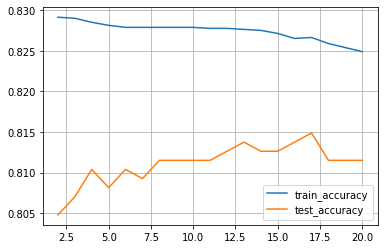

In [28]:
RESULTS_MIN_SAMPLES_SPLIT.plot_and_display_table()

In [29]:
MIN_SAMPLES_SPLIT_RANGE = range(2, 21)

#### min_sample_leaf

In [30]:
RESULTS_MIN_SAMPLES_LEAF = CVResults.from_dict(
    {
        min_samples_leaf: random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                min_samples_leaf=min_samples_leaf,
                random_state=0
            ),
        )
        for min_samples_leaf in range(2, 6)
    }
)


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
2,0.182062,0.029209,0.826288,0.809263,0.877195,0.856605
3,0.175793,0.030000,0.825540,0.809263,0.874747,0.855403
4,0.156886,0.028368,0.825540,0.809263,0.872326,0.859324
5,0.167942,0.028587,0.824542,0.811511,0.870414,0.858045


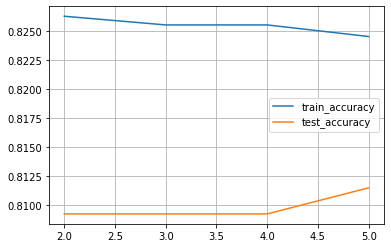

In [31]:
RESULTS_MIN_SAMPLES_LEAF.plot_and_display_table()

In [32]:
MIN_SAMPLES_LEAF_RANGE = range(2, 4)

#### grid searchするぞ
数時間コース

In [34]:
cases = [
    RandomForestParams(*params)
    for params in itertools.product(
        N_ESTIMATOR_RANGE,
        MAX_DEPTH_RANGE,
        MIN_SAMPLES_SPLIT_RANGE,
        MIN_SAMPLES_LEAF_RANGE,
    )
]
RESULTS_GRID_SEARCH = CVResults.from_dict(
    {
        param.to_string(): random_forest_classifier_cross_validation(
            TRAIN,
            RandomForestClassifier(
                n_estimators=param.n_estimators,
                max_depth=param.max_depth,
                min_samples_split=param.min_samples_split,
                min_samples_leaf=param.min_samples_leaf,
                random_state=0
            ),
        )
        for param in tqdm.tqdm(cases)
    }
)


100%|██████████| 18886/18886 [2:06:31<00:00,  2.49it/s]


In [35]:
RESULTS_GRID_SEARCH.to_describe_dataframe().sort_values("test_accuracy", ascending=False)

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc
"n_estimators=75, max_depth=5, min_samples_split=11, min_samples_leaf=2",0.156924,0.028459,0.825041,0.816005,0.872694,0.858481
"n_estimators=59, max_depth=4, min_samples_split=19, min_samples_leaf=3",0.097545,0.018177,0.822921,0.815955,0.863112,0.852184
"n_estimators=71, max_depth=4, min_samples_split=19, min_samples_leaf=2",0.150368,0.028332,0.822796,0.815955,0.863338,0.853794
"n_estimators=45, max_depth=4, min_samples_split=2, min_samples_leaf=3",0.079282,0.015687,0.823295,0.815955,0.863588,0.852645
"n_estimators=45, max_depth=4, min_samples_split=3, min_samples_leaf=3",0.076244,0.015593,0.823295,0.815955,0.863588,0.852645
...,...,...,...,...,...,...
"n_estimators=44, max_depth=9, min_samples_split=3, min_samples_leaf=2",0.071481,0.014584,0.825789,0.804769,0.876916,0.856056
"n_estimators=38, max_depth=4, min_samples_split=18, min_samples_leaf=3",0.057752,0.013895,0.820802,0.804769,0.862358,0.854545
"n_estimators=77, max_depth=4, min_samples_split=17, min_samples_leaf=2",0.173635,0.031298,0.822173,0.804769,0.863875,0.852942
"n_estimators=51, max_depth=4, min_samples_split=20, min_samples_leaf=3",0.088091,0.017640,0.821923,0.803683,0.862991,0.855001


グリッドサーチしても`0.816`そんな変わらない…

In [10]:
OPTIMIZED_PARAMETER = RandomForestParams(n_estimators=75, max_depth=5, min_samples_split=11, min_samples_leaf=2)

## チューニングしたハイパーパラメーターで最終稿出すぞ

In [11]:
OPTIMIZED_RESULT = train_random_forest_classifier(
    TRAIN, TEST, dataclasses.asdict(OPTIMIZED_PARAMETER)
)

array([0.57750662, 0.23187741, 0.05250208, 0.03853481, 0.06152485,
       0.03805423])

0.8316498316498316

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [12]:
OPTIMIZED_RESULT.submit.to_csv("submit_grid_search.csv", index=None)

`score=0.7703`

やったね！0.01あがったね！（微妙かも）